In [131]:
import itertools
from copy import copy
from dataclasses import dataclass, field
from typing import Dict, List, Set, Tuple

import fiona
import geopandas as gp
import networkx as nx
import numpy as np
import osmnx as ox
import seaborn as sns
from matplotlib import colormaps, colors
from matplotlib import pyplot as plt
from shapely.geometry import Point, Polygon
from sklearn import metrics
from sklearn.cluster import AffinityPropagation, KMeans

In [2]:
fiona.listlayers("data/SMARTLOCATIONDB/SmartLocationDb.gdb")

['TIGER2010_bg_SLD']

In [3]:
denver_gdf = ox.geocode_to_gdf("Denver, CO")

In [4]:
denver_buffered_gdf = denver_gdf.to_crs("ESRI:103245").buffer(5_000).to_crs("EPSG:4326")

In [5]:
denver_hull = denver_buffered_gdf.convex_hull[0]

<AxesSubplot:>

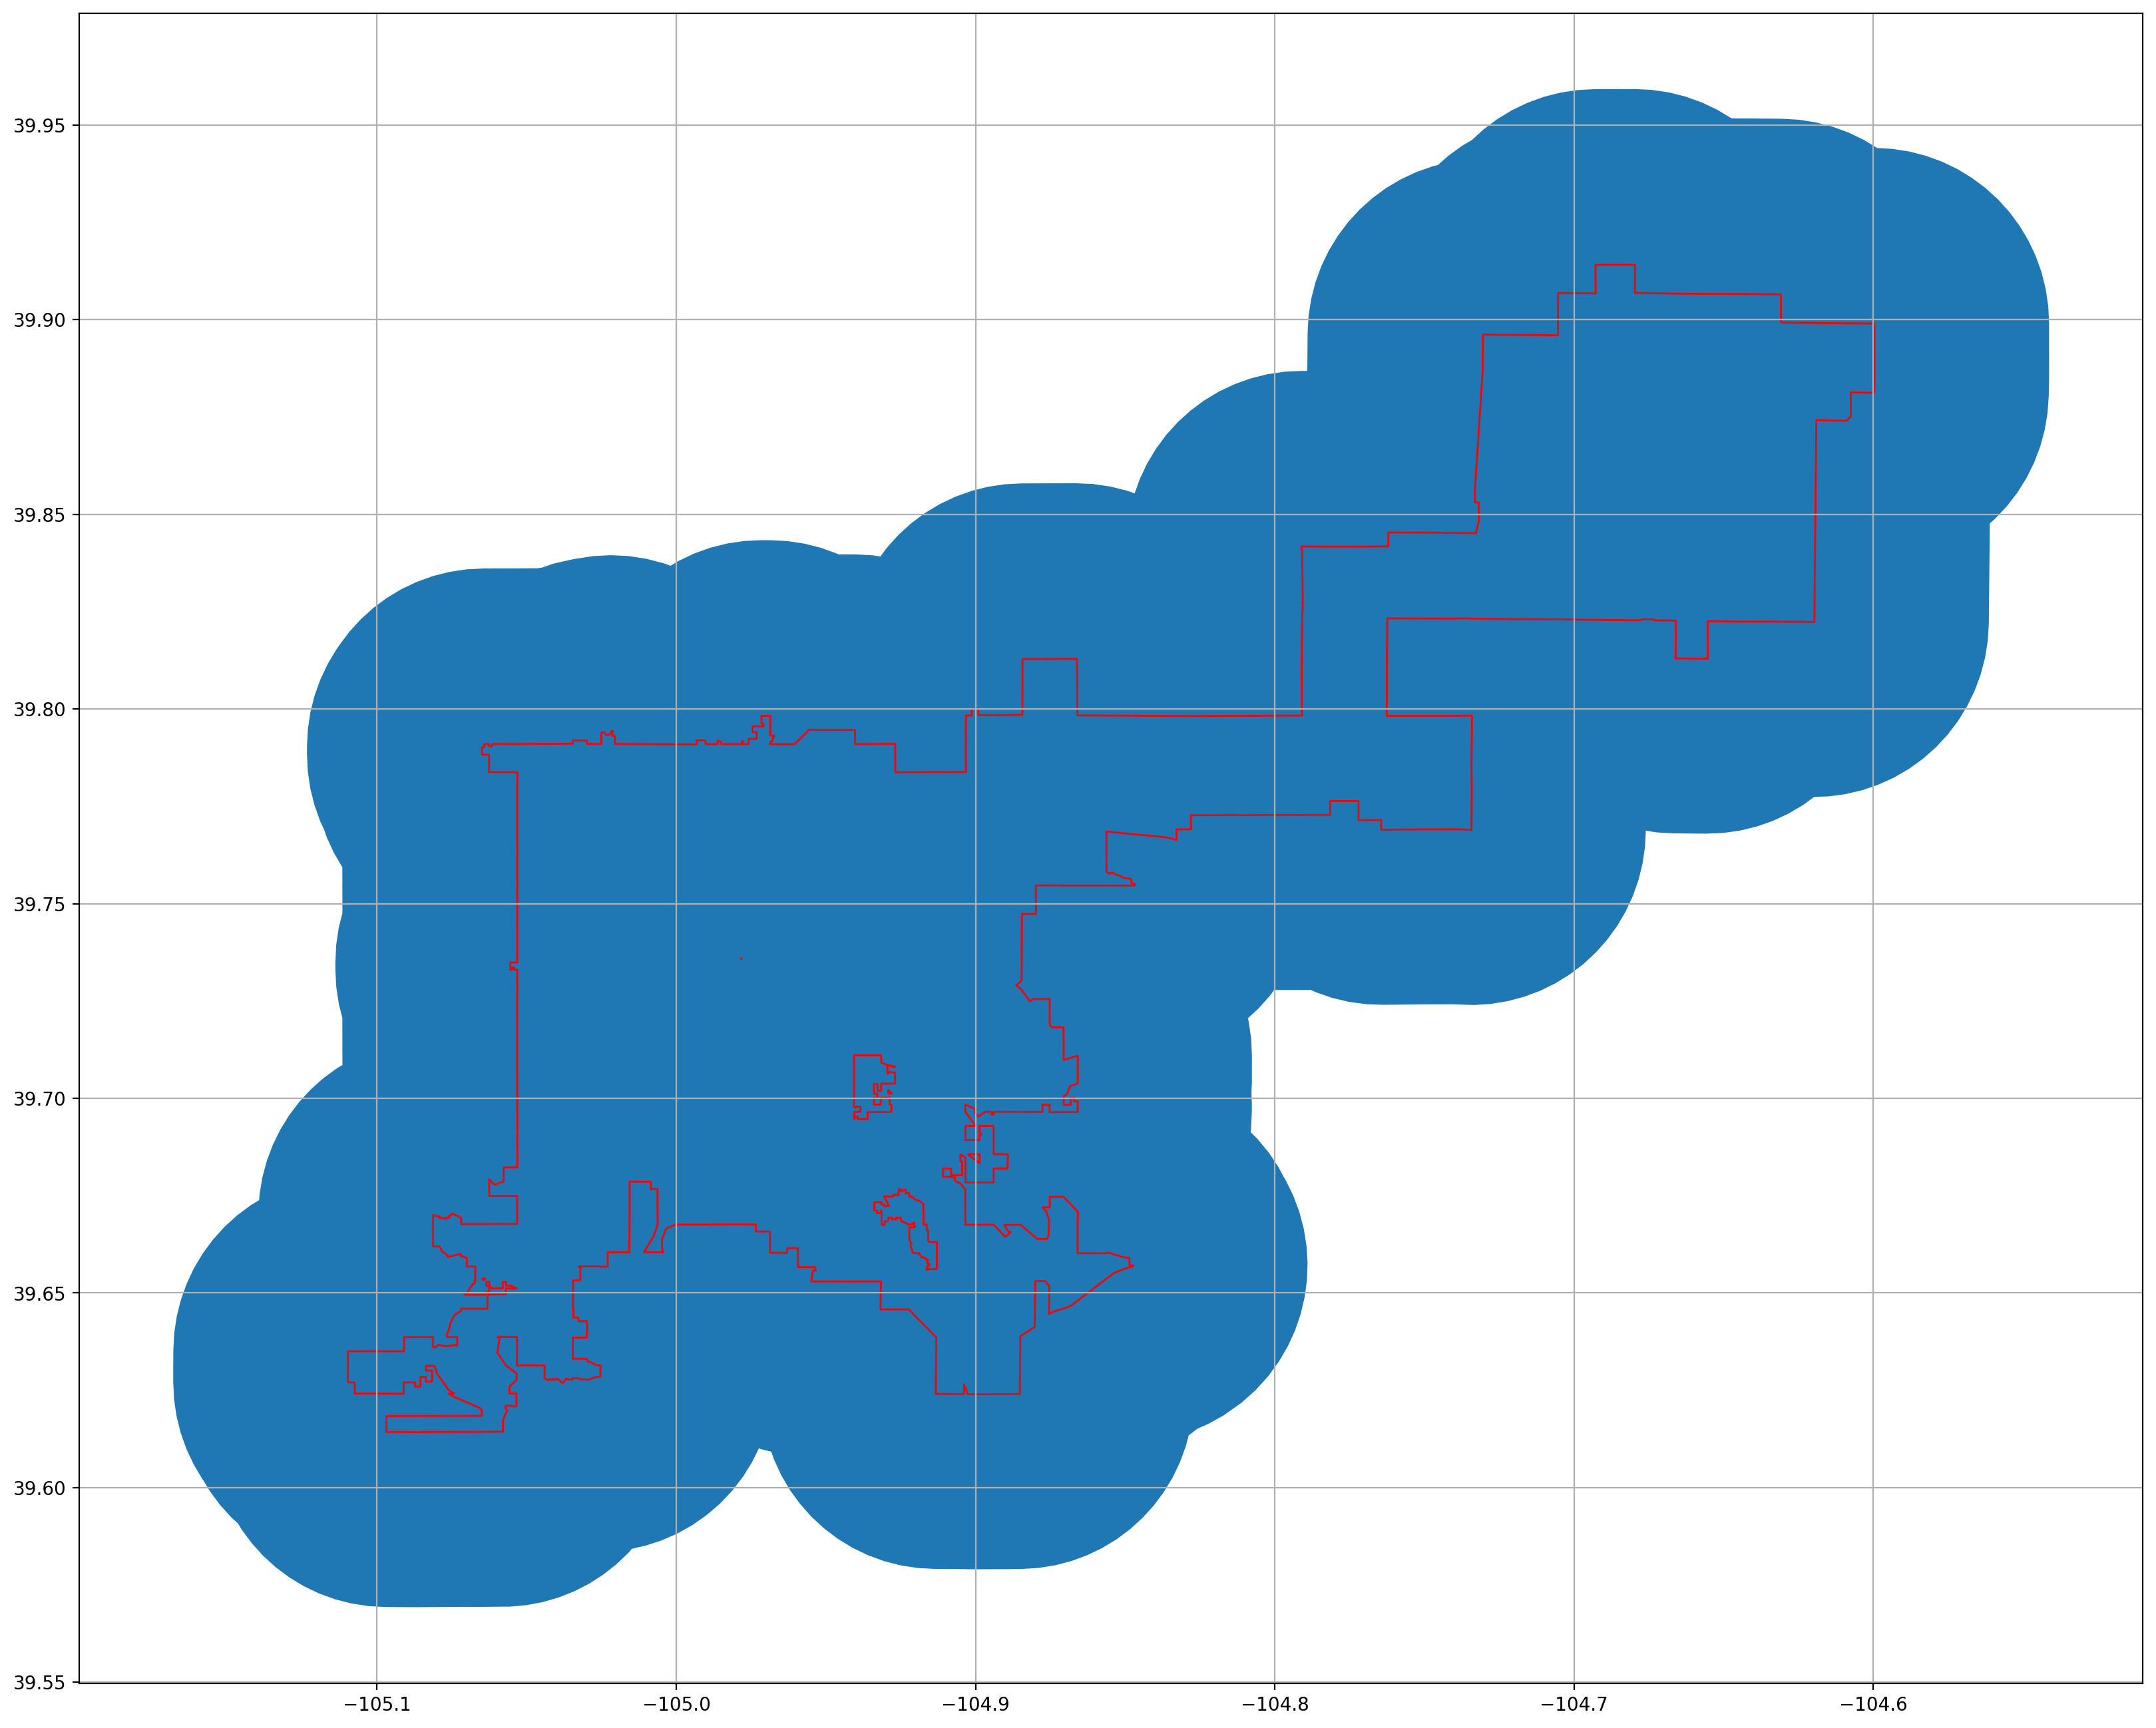

In [6]:
fig, ax = plt.subplots(figsize=(20, 20))
ax.grid()
denver_buffered_gdf.plot(ax=ax)
denver_gdf.plot(ax=ax, edgecolor="red")

In [7]:
smart_locations_db = gp.read_file(
    "data/SMARTLOCATIONDB/SmartLocationDb.gdb",
    driver="FileGDB",
    layer="TIGER2010_bg_SLD",
    bbox=denver_buffered_gdf,
)

<AxesSubplot:>

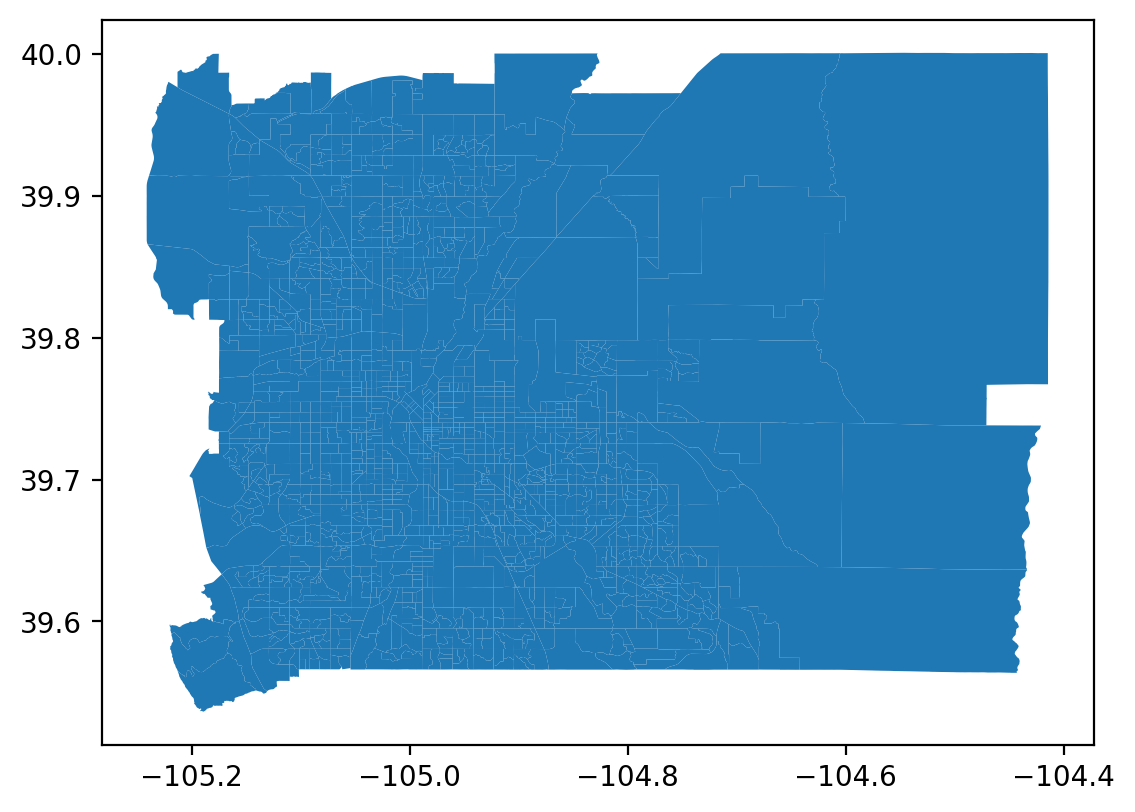

In [8]:
smart_locations_db.plot()

In [9]:
jobs = (
    smart_locations_db["D1C"]
    * smart_locations_db.geometry.to_crs("ESRI:103245").area
    / 4046.86
)

/usr/local/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


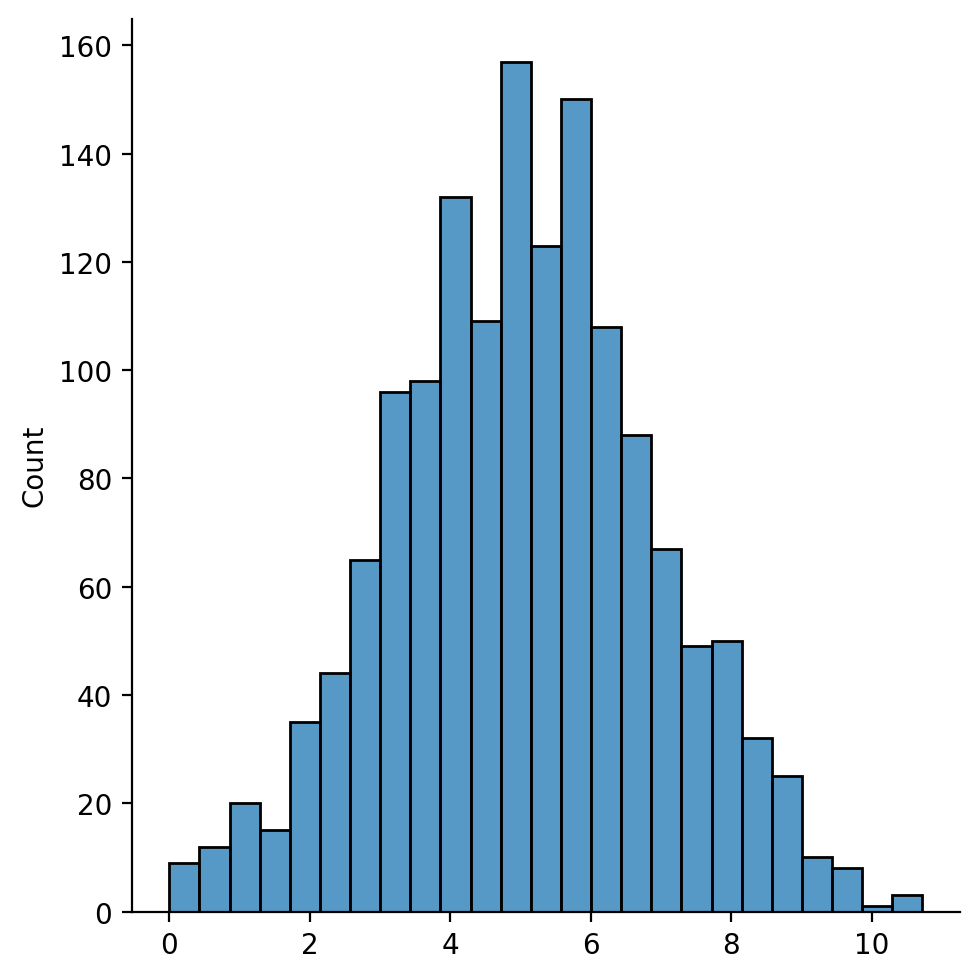

In [10]:
sns.displot(np.log(jobs))

In [11]:
normalizer = colors.LogNorm()
normalizer.autoscale(jobs)

In [13]:
centers = smart_locations_db.geometry.to_crs("ESRI:103245").centroid

In [75]:
np.sum(jobs)

1227751.6007769483

### KMeans

In [67]:
kmeans = KMeans(5)
kmeans.fit(np.array([centers.x, centers.y]).T, sample_weight=jobs)

/usr/local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=5)

In [68]:
mean_centers = gp.GeoDataFrame(
    geometry=[Point(x) for x in kmeans.cluster_centers_], crs="ESRI:103245"
).to_crs("EPSG:4326")

<AxesSubplot:>

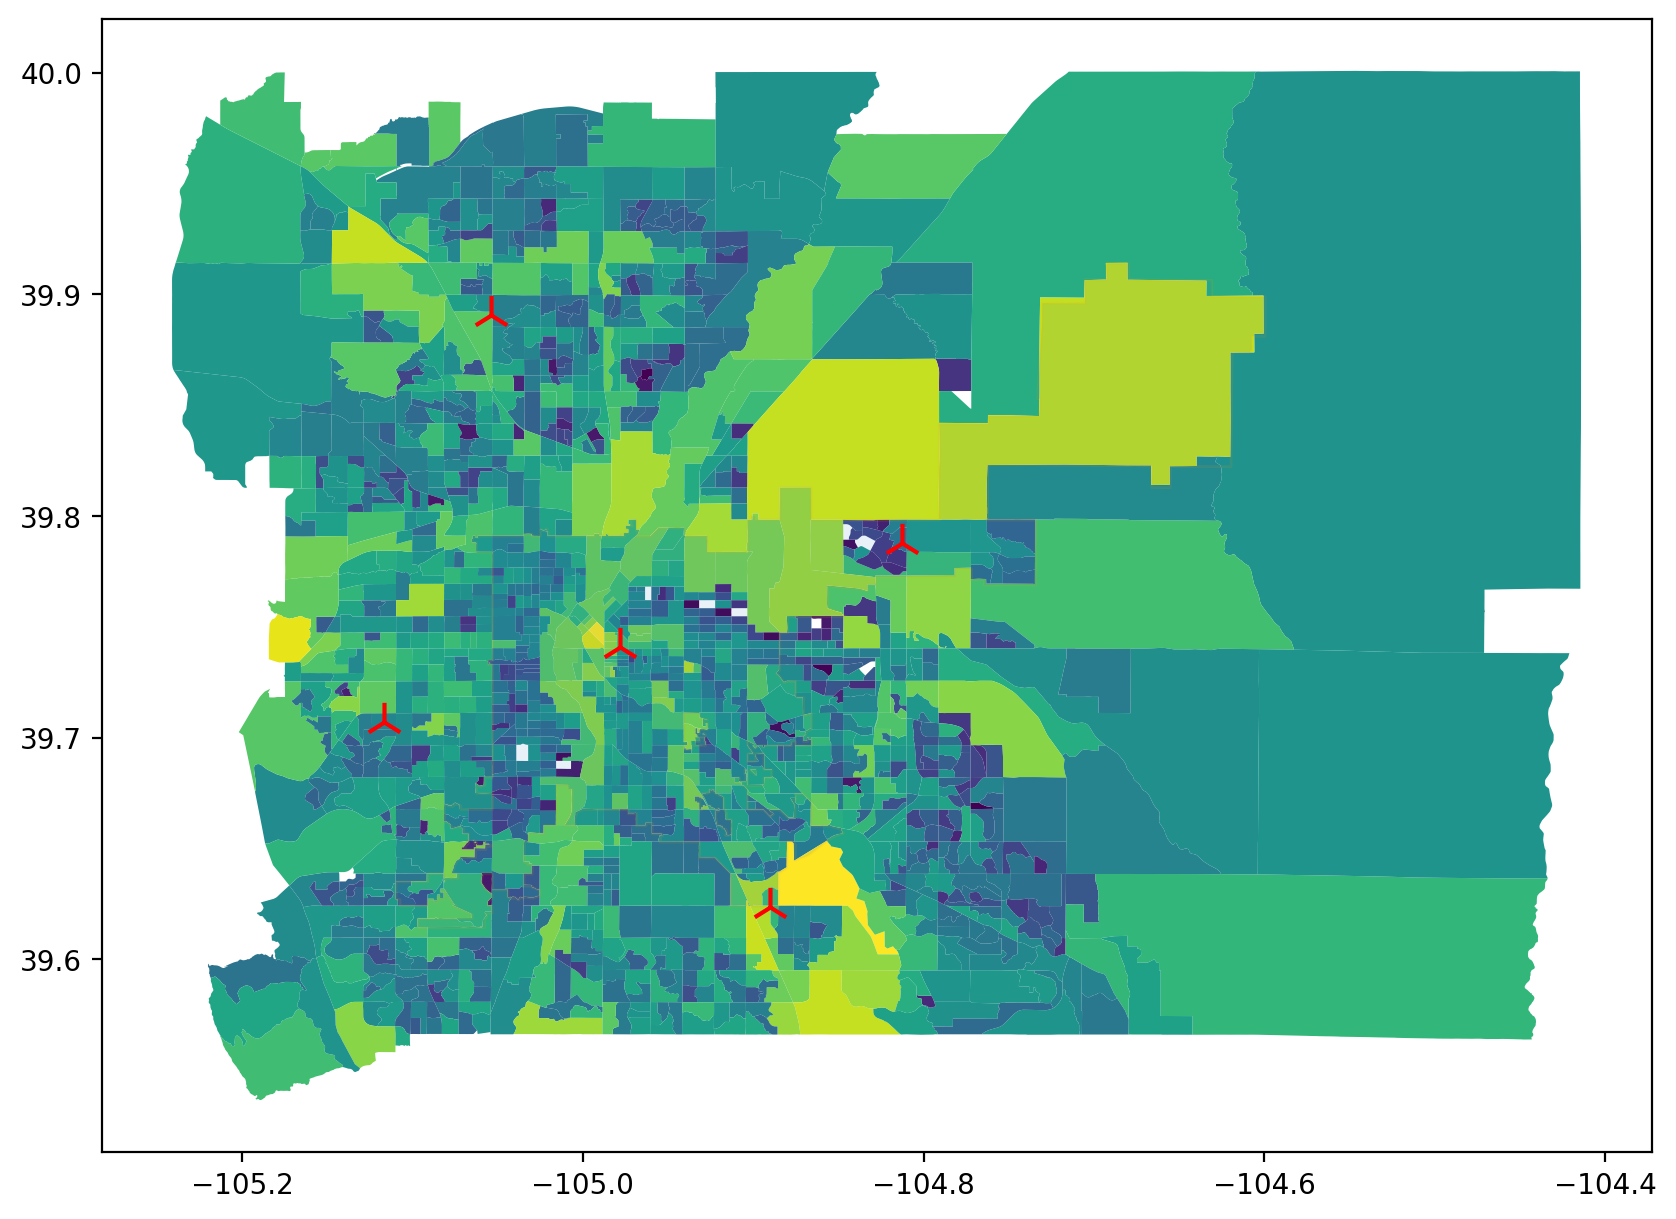

In [69]:
fig, ax = plt.subplots(figsize=(10, 10))

smart_locations_db.plot(
    color=colormaps["viridis"](normalizer(jobs)), figsize=(10, 10), ax=ax
)

denver_gdf.plot(ax=ax, edgecolor="orange", alpha=0.1)
mean_centers.plot(ax=ax, facecolor="red", marker="2", markersize=200)

<AxesSubplot:>

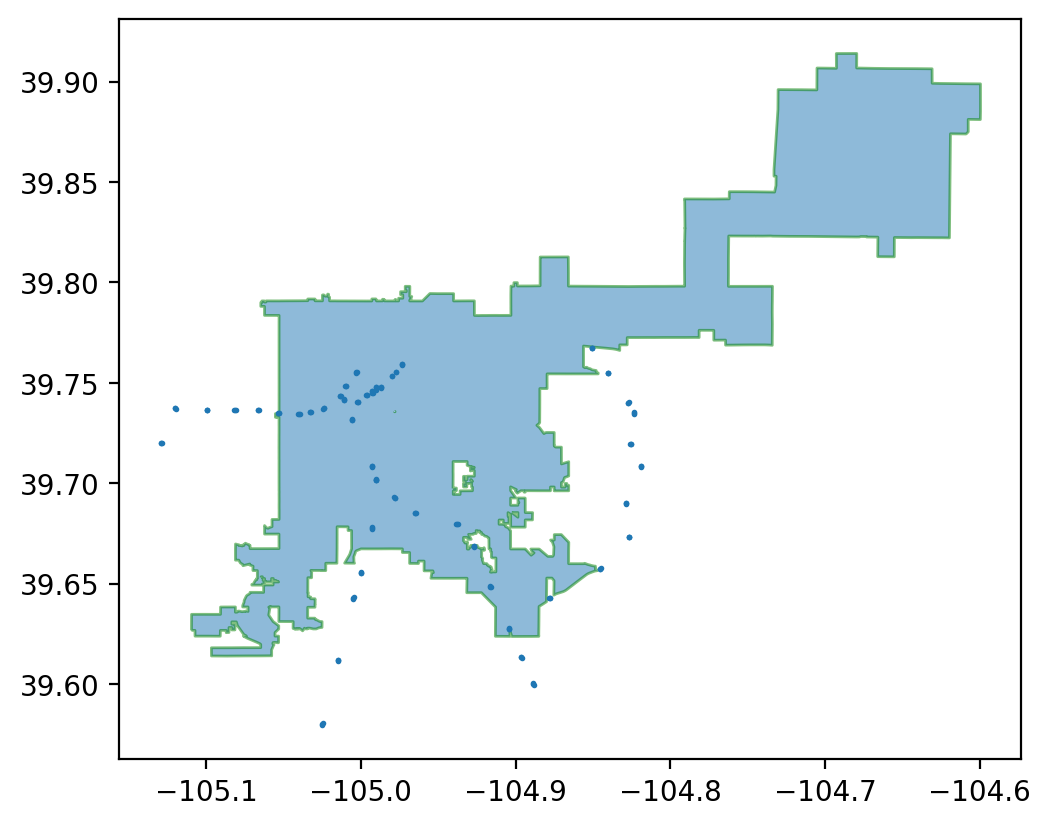

In [70]:
fig, ax = plt.subplots()

denver_gdf.plot(ax=ax, edgecolor="green", alpha=0.5)
gdf = ox.geometries_from_polygon(denver_hull, {"light_rail": "yes"})
# gdf = ox.geometries_from_place("Denver, CO, USA", {"highway": "bus_stop"})
gdf.plot(ax=ax, markersize=1)

In [71]:
gdf["name"]

element_type  osmid    
node          439647509            Littleton - Mineral
              439983297             Littleton Downtown
              442726016                           Yale
              442726036                      Southmoor
              442756657                          Evans
                                      ...             
way           802045307            Auraria West Campus
              802045776    Ball Arena / Elitch Gardens
              802049178                 30th & Downing
              914413723              Louisiana & Pearl
              914413724              Louisiana & Pearl
Name: name, Length: 239, dtype: object

<AxesSubplot:>

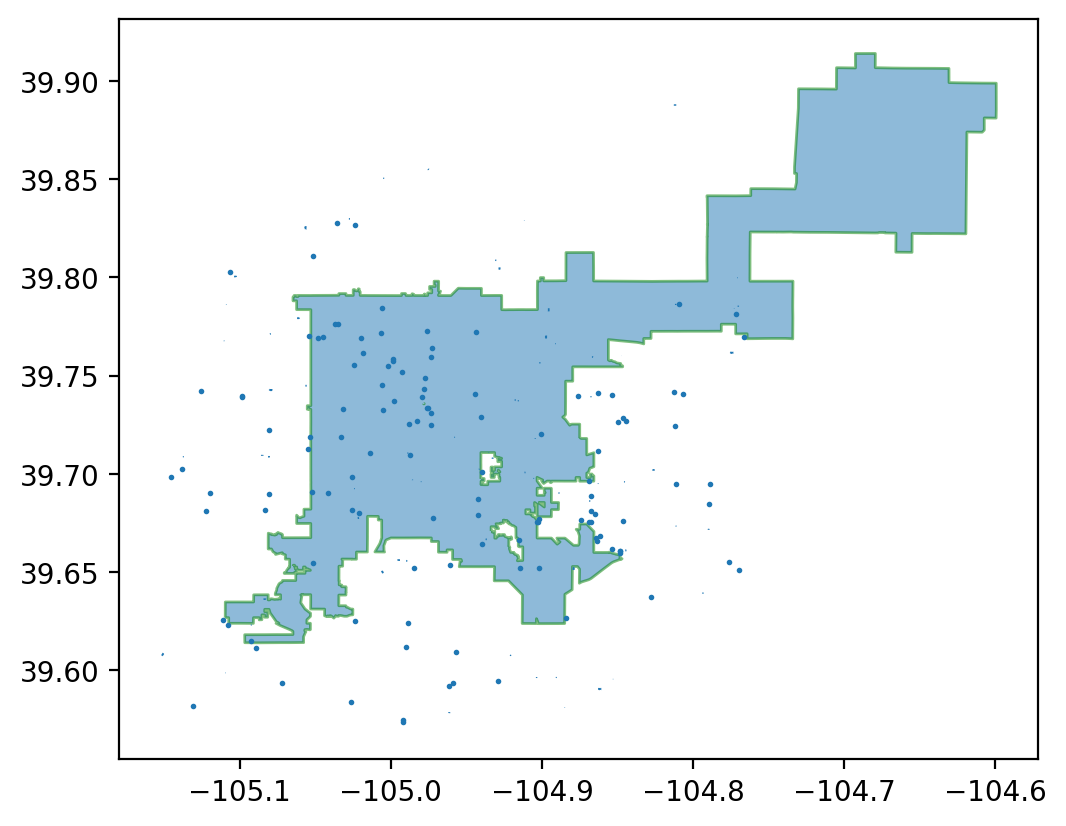

In [180]:
fig, ax = plt.subplots()

denver_gdf.plot(ax=ax, edgecolor="green", alpha=0.5)

gdf = ox.geometries_from_polygon(denver_hull, {"shop": "supermarket"})
gdf.plot(ax=ax, markersize=1)

In [73]:
gdf["name"]

element_type  osmid     
node          442749194               King Soopers
              522136000               King Soopers
              563984326               King Soopers
              566510046               King Soopers
              595869720               King Soopers
                                     ...          
way           1046990001              King Soopers
              1062476805           Natural Grocers
              1072121734    Sprouts Farmers Market
              1133524813    Sprouts Farmers Market
              1145037599                    Target
Name: name, Length: 201, dtype: object

In [181]:
ox.geometries_from_place("Denver, CO, USA", {"public_transport": "*"})

,geometry


In [175]:
# fig, ax = plt.subplots()

# denver_gdf.plot(ax=ax, edgecolor="green", alpha=0.5)
gdf = ox.geometries_from_polygon(denver_hull, {"public_transport": "stop_area"})
gdf
# gdf.plot(ax=ax, markersize=1)

""


In [179]:
ox.geometries_from_point((39.6776734, -104.9928501), {}, dist=500)

,geometry


In [161]:
@dataclass(frozen=True)
class SpatialHashEntry:
    x: float
    y: float
    data: object = field(hash=True)


class SpatialHash:
    cell_size: float
    refinement_factor: float
    data: Dict[List[Tuple[int, int]], Set[SpatialHashEntry]]
    max_depth: int

    def __init__(
        self, cell_size: float, refinement_factor: float = 4, max_depth: int = 10
    ) -> None:
        self.cell_size = cell_size
        self.refinement_factor = refinement_factor
        self.data = dict()
        self.max_depth = max_depth

    def grid_id(self, x: float, y: float) -> List[int]:
        """Get the grid id of the location (x, y)"""

        location = []
        while True:
            cell_x, x = np.divmod(x, self.cell_size)
            cell_y, y = np.divmod(y, self.cell_size)
            x *= self.refinement_factor
            y *= self.refinement_factor
            location += [(cell_x, cell_y)]
            yield tuple(location)

    def insert(self, x: float, y: float, data: object) -> None:
        """Insert data at (x, y)"""
        collisions = set()
        data = SpatialHashEntry(x, y, data)

        for loc in self.grid_id(x, y):
            if loc not in self.data:
                self.data[loc] = set()

            if self.data[loc]:
                # check for collisions
                collisions.update([x for x in self.data[loc] if x is not data])
                self.data[loc].add(data)
            else:
                # No colisions means we're at our leaf
                self.data[loc].add(data)
                break

            # Don't exceede the max depth
            if len(loc) > self.max_depth:
                break

In [162]:
sh = SpatialHash(25)
list(itertools.islice(sh.grid_id(30, 5), 2))

[((1, 0),), ((1, 0), (0, 0))]

In [163]:
sh.insert(30, 55, 1)
sh.insert(30, 50, 2)

In [164]:
sh.data

{((1, 2),): {SpatialHashEntry(x=30, y=50, data=2),
  SpatialHashEntry(x=30, y=55, data=1)},
 ((1, 2), (0, 0)): {SpatialHashEntry(x=30, y=50, data=2)}}

In [183]:
walk_net = ox.graph.graph_from_polygon(denver_hull, network_type="walk")

In [185]:
walk_net

In [191]:
d = ox.geometries_from_address(
    "2163 S Bannock St, Denver, CO, USA", {"building": "residential"}, dist=10
)

In [199]:
print(d.loc[('way', 882557432)].geometry.centroid)

POINT (-104.99020535 39.67731425)


In [200]:
ox.distance.nearest_nodes(walk_net, -104.99020535, 39.67731425)

176076017

In [204]:
walk_nodes, walk_edges = ox.graph_to_gdfs(walk_net)

<AxesSubplot:>

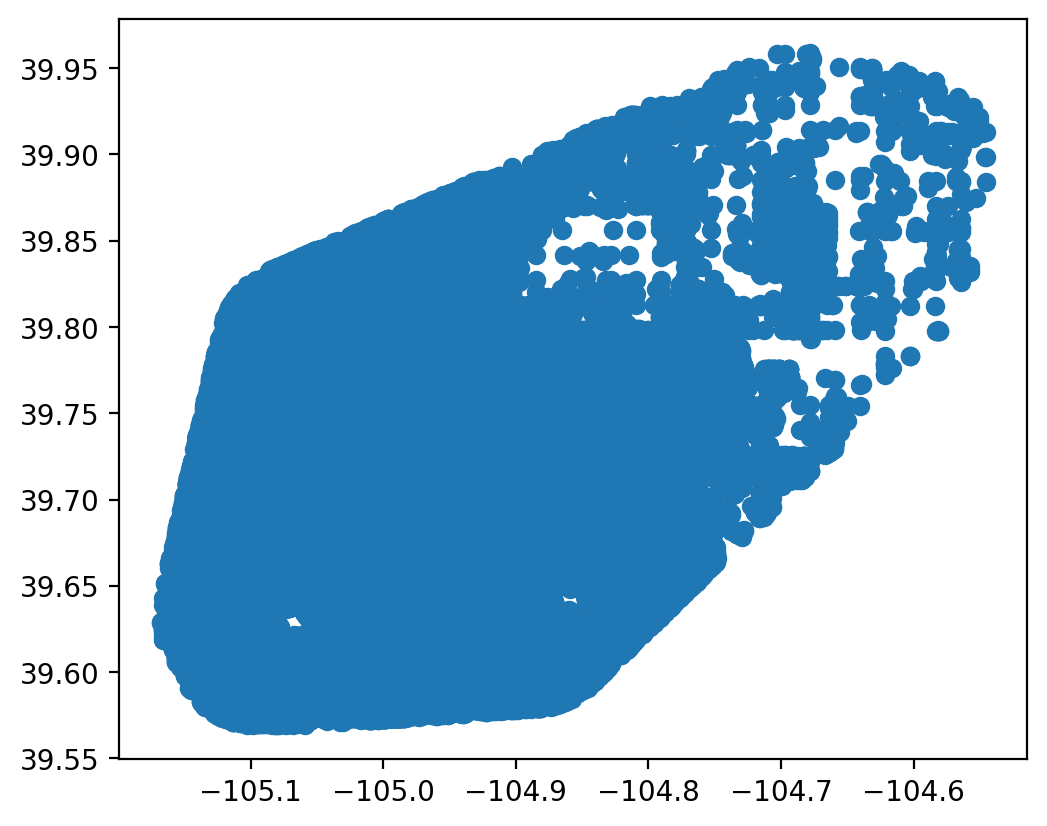

In [205]:
walk_nodes.plot()